In [ ]:
!pip install ranx

In [ ]:
!wget -O trec-pm.tar.xz https://th-koeln.sciebo.de/s/JTTV4fxFmuCGMeY/download
!tar -xf trec-pm.tar.xz

In [ ]:
!wget -O bibliometric.tar.xz https://th-koeln.sciebo.de/s/BRolGxMzrCipoTT/download
!tar -xf bibliometric.tar.xz

In [3]:
# DIR_IN = 'trec-pm/trec-pm-2017-abstracts' 
# DIR_RUN = 'runs/trec-pm-2017-abstracts'    
# PATH_QRELS = "trec-pm/trec-pm-2017-abstracts/qrels-final-abstracts.txt"
# DIR_CSV = 'experimental_results/trec-pm-2017-abstracts/'
# YEAR = 2017

# DIR_IN = 'trec-pm/trec-pm-2018-abstracts' 
# DIR_RUN = 'runs/trec-pm-2018-abstracts'    
# PATH_QRELS = "trec-pm/trec-pm-2018-abstracts/qrels-treceval-abstracts-2018-v2.txt"
# DIR_CSV = 'experimental_results/trec-pm-2018-abstracts/'
# YEAR = 2018

DIR_IN = 'trec-pm/trec-pm-2019-abstracts' 
DIR_RUN = 'runs/trec-pm-2019-abstracts'    
PATH_QRELS = "trec-pm/trec-pm-2019-abstracts/qrels-treceval-abstracts.2019.txt"
DIR_CSV = 'experimental_results/trec-pm-2019-abstracts/'
YEAR = 2019

In [4]:
import os
import gzip

def extract_runs(dir_in, dir_out):

    os.makedirs(dir_out, exist_ok=True)

    for root, dirs, files in os.walk(dir_in):
        for file in files:
            if file.endswith(".gz"):
                run_name = file.split('.')[1]
                with gzip.open(os.path.join(root, file), 'rb') as f_in:
                    file_content = f_in.read()
                    file_out = dir_out + '/' + run_name
                    with open(file_out, 'wb') as f_out:
                        f_out.write(file_content) 
                        if YEAR == 2019:
                            !cat $file_out | cut -d" " -f1 > tmp; mv tmp $file_out
extract_runs(DIR_IN, DIR_RUN)

In [5]:
from ranx import Qrels, Run, evaluate, compare, fuse
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd

def get_run(category, year=2017):
    
    _run = Run()

    df = pd.read_csv('STI_Ergebnisse_final.txt', sep='\t')

    _df = df[df[category].notna()]
    _df = _df[_df['TOPIC'].str.contains(str(year), regex=False)]
    _df = _df[['TOPIC','PUBMED_ID', category]]

    for row in _df.iterrows():
        topic = row[1]['TOPIC'].split('-')[1]
        pubmed_id = row[1]['PUBMED_ID']
        citation_cnt = row[1][category]

        if citation_cnt > 0:
            _run.add_score(str(topic), str(pubmed_id), float(citation_cnt))
    
    return _run

In [6]:
run_cite = get_run('TC', year=YEAR) # get run based on citations
run_alt = get_run('ATTENTION_SCORE', year=YEAR) # get run based on attention score

fuse_method = "rrf"
qrels = Qrels.from_file(PATH_QRELS, kind="trec")

df_data = []

for root, dirs, files in os.walk(DIR_RUN):
    for file in files:
        run = Run.from_file(os.path.join(root, file), kind="trec")
        # run = Run.from_file('runs/trec-pm-2017-abstracts/Broad', kind="trec")
        
        run_rrf = fuse(runs=[run, run_cite, run_alt], method=fuse_method)

        report = compare(
            qrels=qrels,
            runs=[run, run_rrf],
            metrics=["ndcg", "map", "precision@10", "bpref", "mrr"],
            max_p=0.05  
        )

        report_dict = report.to_dict()
        metrics = report_dict.get('metrics')
        base_name = report_dict.get('model_names')[0]
        base_scores = report_dict.get(base_name).get('scores')
        fuse_scores = report_dict.get(fuse_method).get('scores')
        base_pval = report_dict.get(base_name).get('comparisons').get(fuse_method)

        _eval = {'run': base_name}

        for metric in metrics:
            _eval[metric + ' (base)'] = base_scores.get(metric)
            _eval[metric + ' (fuse)'] = fuse_scores.get(metric)
            _eval[metric + ' (diff)'] = fuse_scores.get(metric) - base_scores.get(metric)
            _eval[metric + ' (pval)'] = base_pval.get(metric)
            
        df_data.append(_eval)
        
df = pd.DataFrame(df_data)

os.makedirs(DIR_CSV, exist_ok=True)
file_out = DIR_CSV + fuse_method + '.csv'
df.to_csv(file_out)

/home/breuert/anaconda3/envs/py39/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3357: DtypeWarning: Columns (2,5,7,8,9,10,12,13,14,15,16,18) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/home/breuert/anaconda3/envs/py39/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3357: DtypeWarning: Columns (2,5,7,8,9,10,12,13,14,15,16,18) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


# TREC PM 2017 - Abstracts

## AP

<AxesSubplot:xlabel='run'>

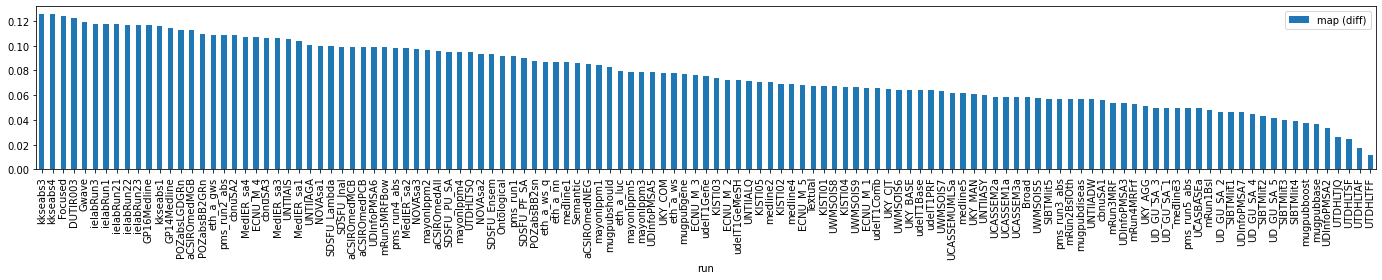

In [66]:
df = pd.read_csv('experimental_results/trec-pm-2017-abstracts/rrf.csv')
df.sort_values(by=['map (diff)'], ascending=False).plot.bar(x='run', y='map (diff)', figsize=(24,3))

## nDCG

<AxesSubplot:xlabel='run'>

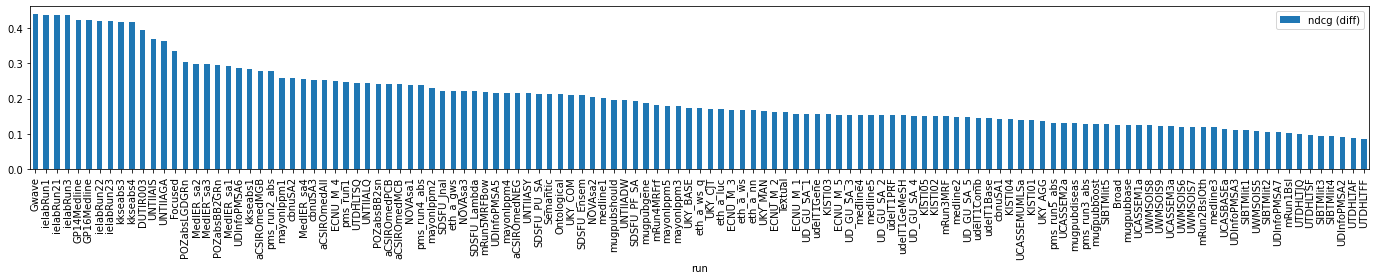

In [68]:
df.sort_values(by=['ndcg (diff)'], ascending=False).plot.bar(x='run', y='ndcg (diff)', figsize=(24,3))

## P@10

<AxesSubplot:xlabel='run'>

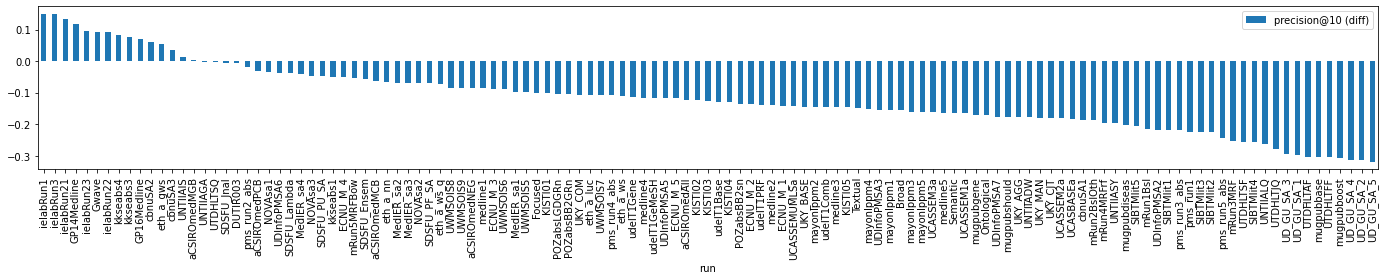

In [69]:
df.sort_values(by=['precision@10 (diff)'], ascending=False).plot.bar(x='run', y='precision@10 (diff)', figsize=(24,3))

## Bpref

<AxesSubplot:xlabel='run'>

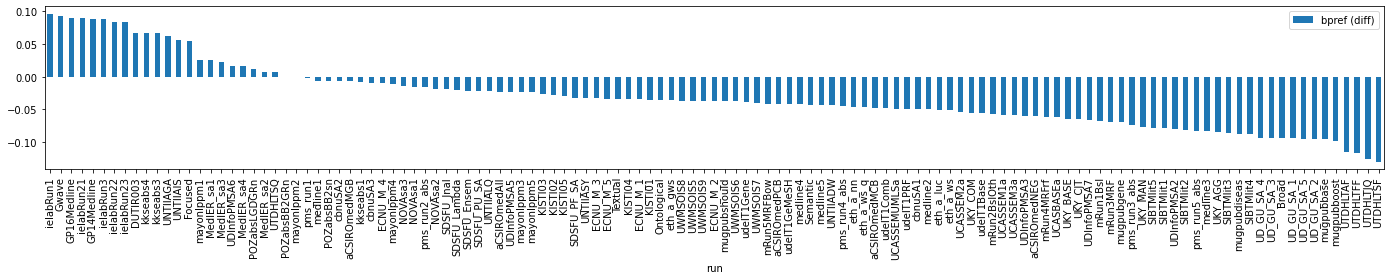

In [70]:
df.sort_values(by=['bpref (diff)'], ascending=False).plot.bar(x='run', y='bpref (diff)', figsize=(24,3))

## MRR

<AxesSubplot:xlabel='run'>

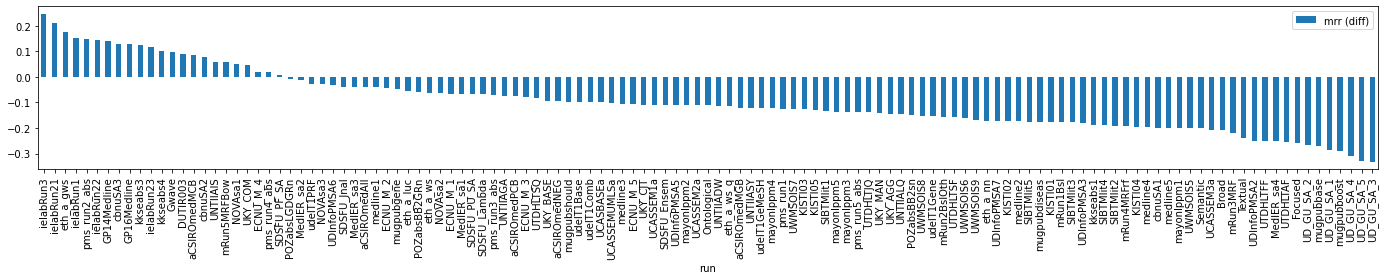

In [71]:
df.sort_values(by=['mrr (diff)'], ascending=False).plot.bar(x='run', y='mrr (diff)', figsize=(24,3))

# TREC PM 2018 - Abstracts

## AP

<AxesSubplot:xlabel='run'>

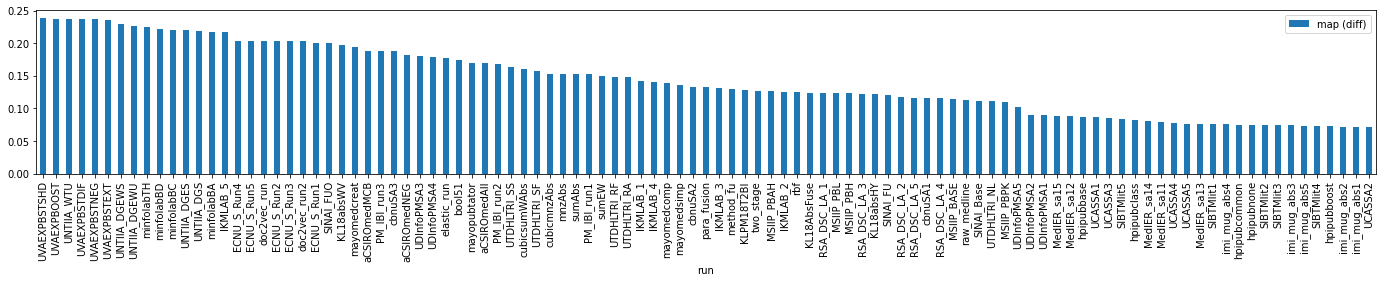

In [72]:
df = pd.read_csv('experimental_results/trec-pm-2018-abstracts/rrf.csv')
df.sort_values(by=['map (diff)'], ascending=False).plot.bar(x='run', y='map (diff)', figsize=(24,3))

## nDCG

<AxesSubplot:xlabel='run'>

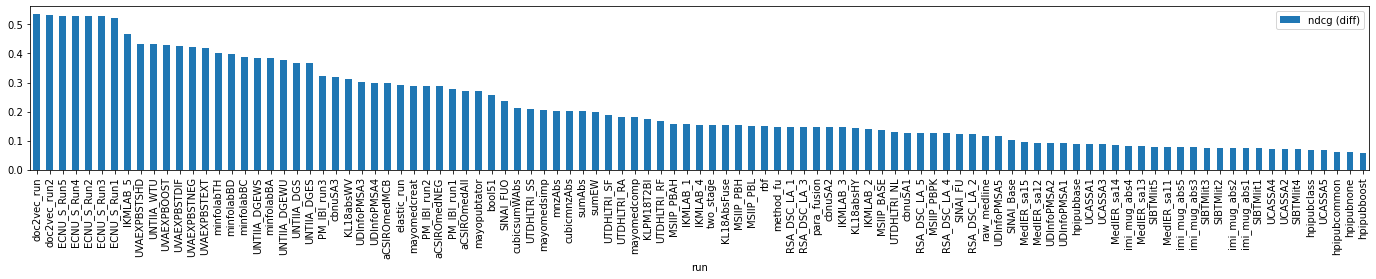

In [73]:
df.sort_values(by=['ndcg (diff)'], ascending=False).plot.bar(x='run', y='ndcg (diff)', figsize=(24,3))

## P@10

<AxesSubplot:xlabel='run'>

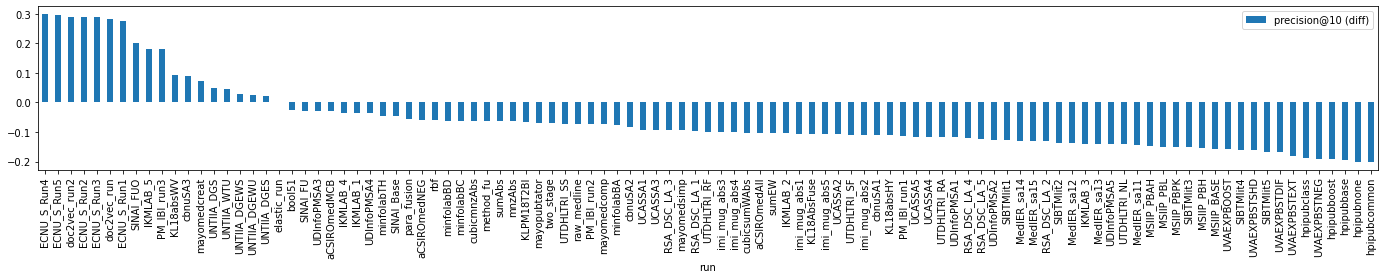

In [74]:
df.sort_values(by=['precision@10 (diff)'], ascending=False).plot.bar(x='run', y='precision@10 (diff)', figsize=(24,3))

## Bpref

<AxesSubplot:xlabel='run'>

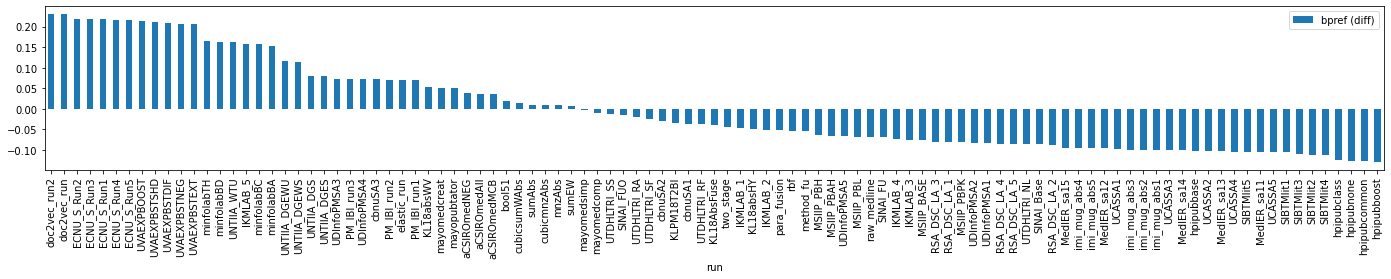

In [76]:
df.sort_values(by=['bpref (diff)'], ascending=False).plot.bar(x='run', y='bpref (diff)', figsize=(24,3))

## MRR

<AxesSubplot:xlabel='run'>

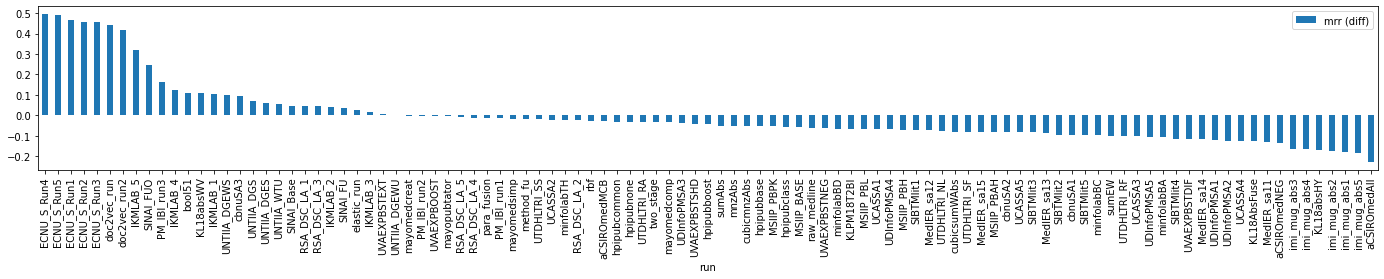

In [78]:
df.sort_values(by=['mrr (diff)'], ascending=False).plot.bar(x='run', y='mrr (diff)', figsize=(24,3))

# TREC PM 2019 - Abstracts

## AP

<AxesSubplot:xlabel='run'>

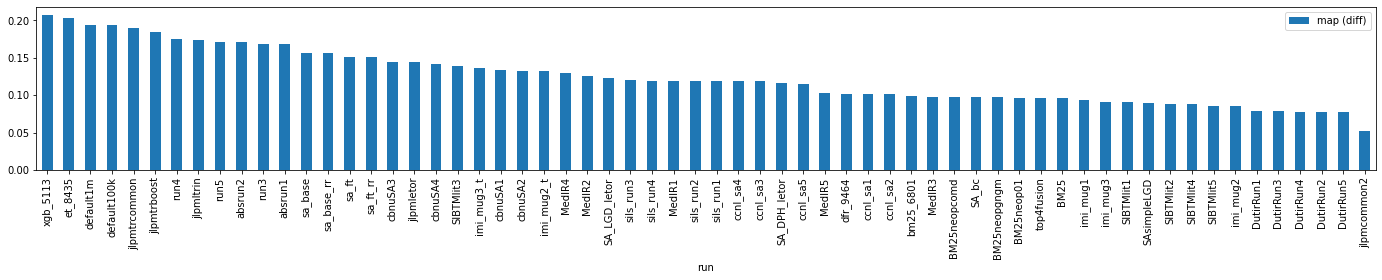

In [8]:
df = pd.read_csv('experimental_results/trec-pm-2019-abstracts/rrf.csv')
df.sort_values(by=['map (diff)'], ascending=False).plot.bar(x='run', y='map (diff)', figsize=(24,3))

## nDCG

<AxesSubplot:xlabel='run'>

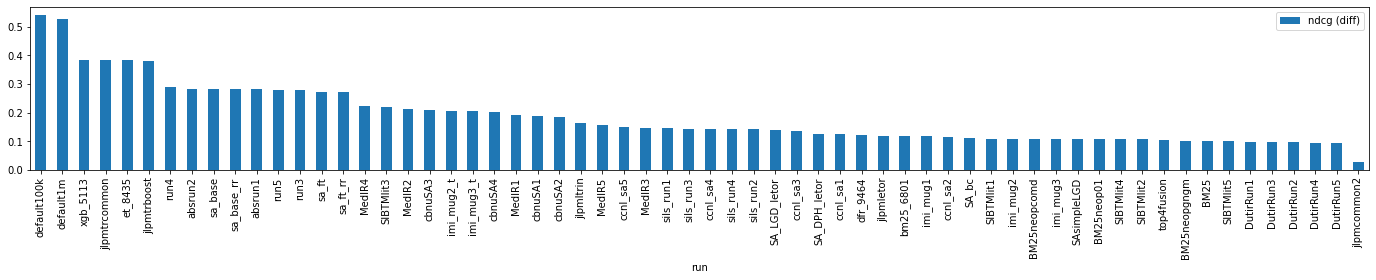

In [9]:
df.sort_values(by=['ndcg (diff)'], ascending=False).plot.bar(x='run', y='ndcg (diff)', figsize=(24,3))

## P@10

<AxesSubplot:xlabel='run'>

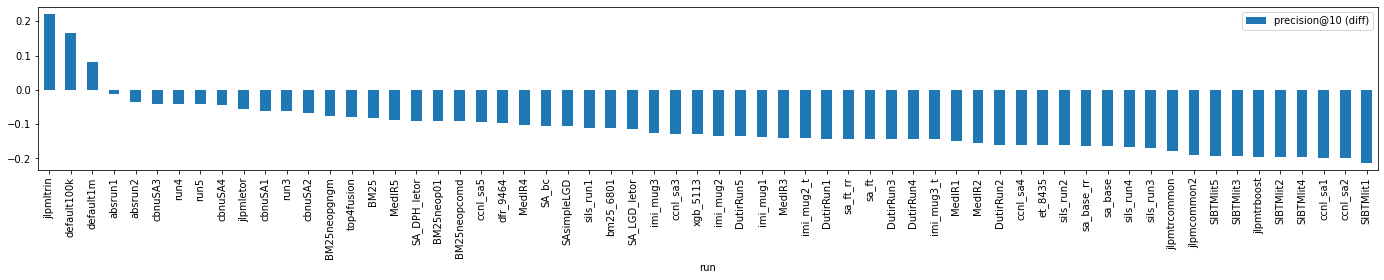

In [10]:
df.sort_values(by=['precision@10 (diff)'], ascending=False).plot.bar(x='run', y='precision@10 (diff)', figsize=(24,3))

## Bpref

<AxesSubplot:xlabel='run'>

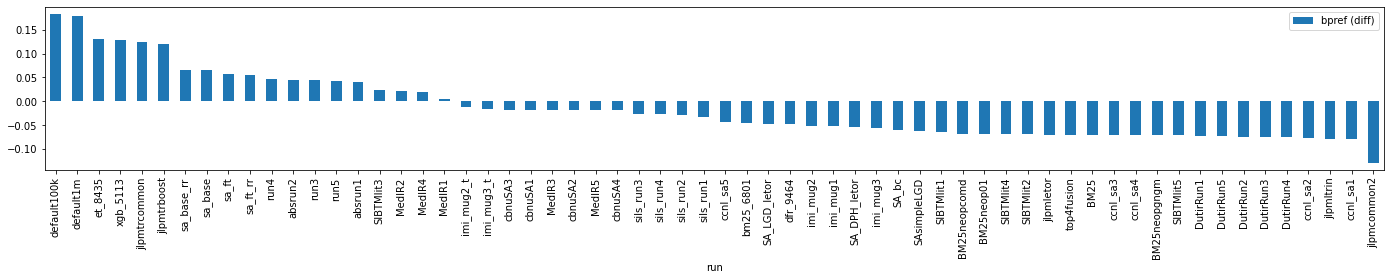

In [11]:
df.sort_values(by=['bpref (diff)'], ascending=False).plot.bar(x='run', y='bpref (diff)', figsize=(24,3))

## MRR

<AxesSubplot:xlabel='run'>

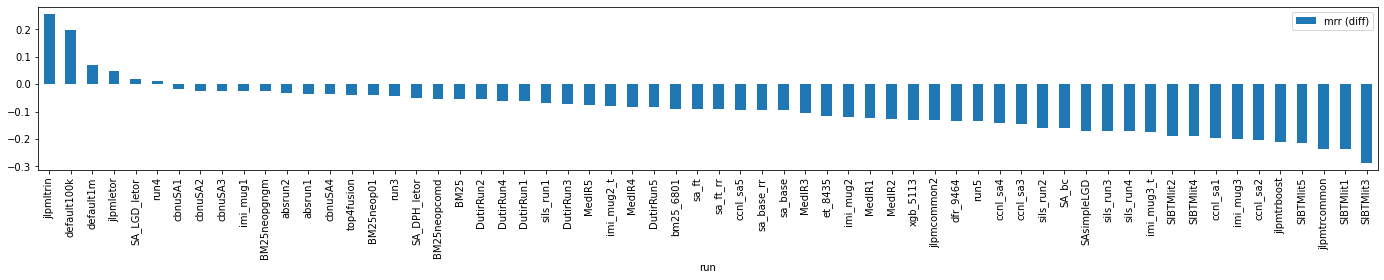

In [12]:
df.sort_values(by=['mrr (diff)'], ascending=False).plot.bar(x='run', y='mrr (diff)', figsize=(24,3))